In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

import numpy as np
from pyannote.core import SlidingWindow, SlidingWindowFeature, Annotation, Timeline, Segment

from diart.models import EmbeddingModel, SegmentationModel
from diart import SpeakerDiarization, SpeakerDiarizationConfig

from utils import load_audio

hf_token = os.environ.get("HF_TOKEN")

segmentation = SegmentationModel.from_pretrained("pyannote/segmentation-3.0", use_hf_token=hf_token)
embedding = EmbeddingModel.from_pretrained("nvidia/speakerverification_en_titanet_large", use_hf_token=hf_token)

config = SpeakerDiarizationConfig(
    segmentation=segmentation,
    embedding=embedding
)
pipeline = SpeakerDiarization(config)

/home/raid/miniconda3/envs/nemo/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:datasets:PyTorch version 2.6.0+cu126 available.
[NeMo W 2025-03-03 10:48:47 nemo_logging:361] /home/raid/miniconda3/envs/nemo/lib/python3.10/site-packages/diart/audio.py:8: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
      torchaudio.set_audio_backend("soundfile")
    
[NeMo W 2025-03-03 10:48:49 modelPT:176] If you intend to do training or fine-tuning, please call the Mod

[NeMo I 2025-03-03 10:48:49 features:305] PADDING: 16
[NeMo I 2025-03-03 10:48:49 save_restore_connector:275] Model EncDecSpeakerLabelModel was successfully restored from /home/raid/.cache/huggingface/hub/models--nvidia--speakerverification_en_titanet_large/snapshots/0dc382f40121a5fbd34db10a2bb04d826c2be6a8/speakerverification_en_titanet_large.nemo.


In [3]:
waveform, sample_rate = load_audio('toefl_eg.mp3')

In [4]:
pipeline.config.duration

5

In [5]:
pipeline.config.step

0.5

In [6]:
from tqdm.notebook import tqdm

In [25]:
np.array((((123), (123), (123), (123)), ((123), (123), (123), (123)))).shape

(2, 4)

  0%|          | 0/500 [00:00<?, ?it/s]

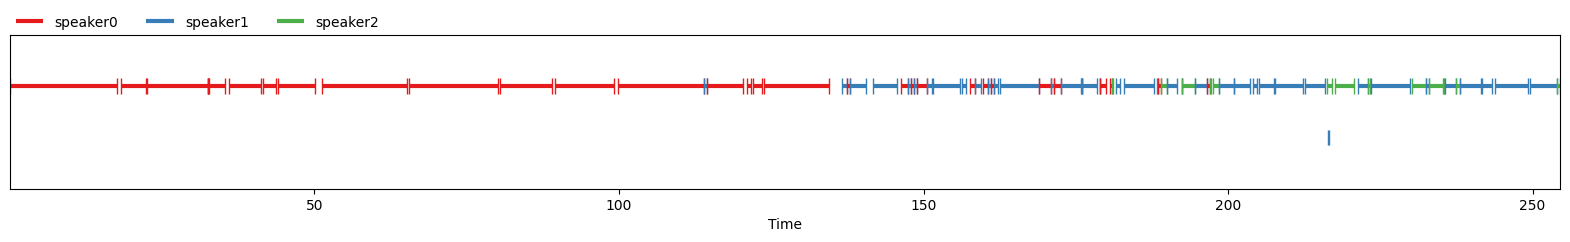

In [7]:
# Create an empty annotation to store the combined results
merged_annotation = Annotation()

for i in tqdm(range(500)):
    duration = int(pipeline.config.duration * pipeline.config.sample_rate)
    step = int(pipeline.config.step * pipeline.config.sample_rate)
    
    audio = waveform[0, step*i:duration+step*i].unsqueeze(-1).numpy()
    
    # Obtain and format audio
    sample_rate = pipeline.config.sample_rate
    sliding_window = SlidingWindow(
        start=i * pipeline.config.step,
        duration=1.0 / sample_rate,
        step=1.0 / sample_rate,
    )
    audio = SlidingWindowFeature(audio, sliding_window)
    
    # Get annotation for this chunk
    annotation, audio_chunk = pipeline([audio])[0]

    merged_annotation.update(annotation)

    # print('updated')
    # print(merged_annotation)
    
    # For the first chunk, simply use the full annotation
    # if i == 0:
    #     merged_annotation = annotation.copy()
    # else:
    #     for segment, track, label in annotation.itertracks(yield_label=True):
    #         print(segment)
    #         print(track)
    #         print(label)
        # For subsequent chunks, only consider the new part
        # Calculate the segment representing the new portion
        # new_segment_start = i * pipeline.config.step
        # new_segment_end = new_segment_start + pipeline.config.step
        # new_segment = Segment(new_segment_start, new_segment_end)

        # print(new_segment)
        
        # # Extract annotations from the current chunk that fall within the new segment
        # for segment, track, label in annotation.itertracks(yield_label=True):
        #     # Check if this segment overlaps with our "new" section
        #     segment_overlap = segment & new_segment
        #     merged_annotation[segment_overlap, track] = label

merged_annotation.support(0.05)

In [13]:
print(merged_annotation.support(0.25).to_rttm())

SPEAKER <NA> 1 0.009 17.500 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 18.258 17.033 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 35.925 5.317 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 41.608 8.400 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 51.192 28.867 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 80.508 8.567 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 89.492 9.667 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 99.908 14.100 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 114.008 0.500 <NA> <NA> speaker1 <NA> <NA>
SPEAKER <NA> 1 114.508 5.850 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 121.042 0.617 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 122.058 1.383 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 123.742 10.767 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 136.675 0.833 <NA> <NA> speaker1 <NA> <NA>
SPEAKER <NA> 1 137.508 0.500 <NA> <NA> speaker0 <NA> <NA>
SPEAKER <NA> 1 138.008 2.550 <NA> <NA> speaker1 <NA> <NA>
SPEAKER <NA> 1 141.708 3.917 <NA> <NA> speaker1 <NA> <NA>
SPEAKER <NA> 1 146

In [9]:
print(annotation)

[ 00:00:06.508 -->  00:00:07.008] 0 speaker0
